# Hyperparamater Optimization at Scale with XGBoost, Optuna, and Dask

In the example on {doc}`hpo`, we saw how to perform hyperparameter optimization with Dask + Optuna + XGBoost for a case where the data fits comfortably in memory. But when the data doesn't fit comfortably in memory, we would like to parallelize each XGBoost call with Dask. However, the current `xgboost.dask` implementation takes over the entire Dask cluster, so running many of these at once is problematic.

In this guide, you'll learn how to perform hyperparameter optimization using Optuna with multiple Dask clusters that train several models using `xgboost.dask`. This work extends the example shown in {doc}`hpo`, but now we'll run many model trainings in parallel, each model running in a separate Dask cluster. Download {download}`this jupyter notebook <xgboost-hpo.ipynb>` or check out <https://github.com/coiled/dask-xgboost-nyctaxi> to run this example yourself.

<iframe width="560" height="315" src="https://www.youtube.com/embed/Hh_6X6VFm-E" data-hj-allow-iframe="true" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

In this example we:

- Load a single, consistent dataset from S3.
- Create multiple Dask clusters using Coiled, one per each thread in a local thread pool.
- Run Optuna locally on that thread pool.


:::{figure-md}
<img src="https://raw.githubusercontent.com/coiled/dask-xgboost-nyctaxi/main/Modeling_3.svg"
     width=800px
     alt="multi cluster diagram">

Conceptual diagram of using multiple clusters (click to enlarge)
:::


## Before you start

You'll first need install the necessary packages. For the purposes of this example, we'll do this in a new virtual environment, but you could also install them in whatever environment you're already using for your project.

```bash
$ conda create -n parallel-hpo-mc-example -c conda-forge python=3.10 dask coiled s3fs pyarrow dask-ml optuna matplotlib
$ conda activate parallel-hpo-mc-example
$ pip install xgboost
```
  
You also could use `pip` for everything, or any other package manager you prefer; `conda` isn't required.

When you create a cluster, Coiled will automatically replicate your local `parallel-hpo-mc-example` environment to your cluster.

## About the Data

In this example we will use a dataset that the Coiled team created by pre-processing the
Uber/Lyft dataset from the [High-Volume For-Hire Services](https://www.nyc.gov/site/tlc/businesses/high-volume-for-hire-services.page), joined it with the [NYC Taxi Zone Lookup Table](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page). This results in a dataset with ~1.4 billion rows. 

## About the Model

Each Dask Cluster will be  be training a single XGBoost model with Dask using the `xgboost.dask` module built into XGBoost.

- Load the data
- Perform basic feature engineering (date type optimization, categorization)
- Train a single model with XGBoost, using custom cross-validation

(get_ddf)=
## Get Clusters and Data

In [2]:
import threading
from typing import Dict

import coiled
import dask
import dask.dataframe as dd
import distributed
import numpy as np

# Dask workers per cluster
N_WORKERS = 50

# Total number of EC2 instances spun up = N_JOBS * N_WORKERS where NJOBS is
# the number of parallel optuna jobs to run


# We cache the results in a clusters dictionary
clusters: Dict[int, tuple[distributed.Client, dd.DataFrame]] = {}


def get_ddf() -> tuple[distributed.Client, dd.DataFrame]:
    thread_id = threading.get_ident()
    # checking if there are already results cached for a given thread
    # if so, return them. If not, continue with the rest of the function
    try:
        return clusters[thread_id]
    except KeyError:
        pass

    cluster = coiled.Cluster(
        name=f"xgb-nyc-taxi-gbh-{thread_id}",
        worker_vm_types=["r6i.large"],
        scheduler_vm_types=["m6i.large"],
        n_workers=N_WORKERS,
        show_widget=False,
        backend_options={
            "region": "us-east-2",
            "multizone": True,
        },
        scheduler_options={"idle_timeout": "15 minutes"},
    )

    client = distributed.Client(cluster, set_as_default=False)
    print("Started cluster at", client.dashboard_link)

    with client.as_current():
        # load data
        ddf = dd.read_parquet(
            "s3://coiled-datasets/dask-xgboost-example/feature_table.parquet/"
        )

        # Reduce dataset size. Uncomment to speed up the exercise.
        # ddf = ddf.partitions[:20]

        # Basic feature Engineering
        # Under the hood, XGBoost converts floats to `float32`.
        # Let's do it only once here.
        float_cols = ddf.select_dtypes(include="float").columns.tolist()
        ddf = ddf.astype({c: np.float32 for c in float_cols})

        # We need the categories to be known
        categorical_vars = ddf.select_dtypes(include="category").columns.tolist()

        # categorize() reads the whole input and then discards it.
        # Let's read from disk only once.
        ddf = ddf.persist()
        ddf = ddf.categorize(columns=categorical_vars, scheduler=client)

        # We will need to access this multiple times. Let's persist it.
        ddf = ddf.persist()

        clusters[thread_id] = client, ddf
        return client, ddf

## Custom cross-validation

In this example we show you how you can use a custom cross-validation function such as:

In [4]:
from collections.abc import Iterator

# Number of folds determines the train/test split
# (e.g. N_FOLDS=5 -> train=4/5 of the total data, test=1/5)
N_FOLDS = 5


def make_cv_splits(
    ddf: dd.DataFrame, n_folds: int = N_FOLDS
) -> Iterator[tuple[dd.DataFrame, dd.DataFrame]]:
    frac = [1 / n_folds] * n_folds
    splits = ddf.random_split(frac, shuffle=True)
    for i in range(n_folds):
        train = [splits[j] for j in range(n_folds) if j != i]
        test = splits[i]
        yield dd.concat(train), test

## Train Model
Notice that we are training one model per cluster. 

When using XGBoost with Dask, we need to call the XGBoost Dask interface from the client side. The main difference with XGBoost’s Dask interface is that we pass our Dask client as an additional argument for carrying out the computation. Note that if the `client` parameter below is set to `None`, XGBoost will use the default client returned by Dask.


In [6]:
from typing import Dict

import dask.array as da
import xgboost
from dask_ml.metrics import mean_squared_error

def train_model(study_params: Dict[str, float]) -> float:
    scores = []
    client, ddf = get_ddf()

    with client.as_current():
        for train, test in make_cv_splits(ddf):
            y_train = train["trip_time"]
            X_train = train.drop(columns=["trip_time"])
            y_test = test["trip_time"]
            X_test = test.drop(columns=["trip_time"])

            d_train = xgboost.dask.DaskDMatrix(
                client, X_train, y_train, enable_categorical=True
            )
            model = xgboost.dask.train(
                client,
                {"tree_method": "hist", **study_params},
                d_train,
                num_boost_round=4,
                evals=[(d_train, "train")],
            )
            predictions = xgboost.dask.predict(None, model, X_test)
            score = mean_squared_error(
                y_test.to_dask_array(),
                predictions.to_dask_array(),
                squared=False,
                compute=False,
            )
            # Compute predictions and mean squared error for this iteration
            # while we start the next one
            scores.append(score.reshape(1).persist())
            del d_train, model, predictions, score

        scores = da.concatenate(scores).compute()
        return scores.mean()

## Create objective function

In this example we use Optuna to optimize several hyperparametersto train an XGBoost model. There is no Dask-specific code here. This is exactly the same code you would write if you were to run Optuna on your local machine.

In [7]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 75, 125),
        "learning_rate": trial.suggest_float("learning_rate", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
        "max_depth": trial.suggest_int("max_depth", 1, 6),
        "max_leaves": trial.suggest_int("max_leaves", 0, 2),
        "max_cat_to_onehot": trial.suggest_int("max_cat_to_onehot", 1, 10),
    }
    return train_model(params)

## Create a single Optuna study

In [8]:
from datetime import datetime
import optuna

:::{note}
The following cell will start 10 clusters, and perform 50 trials accross those clusters where each trial will train an xgboost model with 5 folds cross validation. These take approximately ~1.5hours. If you want to experiment with this example we recommend using a small set of the data (see instructions in `get_ddf` function {ref}`above <get_ddf>`), or reducing the amount of trials (see final plot for reference on convergence)
:::

In [9]:
%%time
# Number of parallel optuna jobs to run
N_JOBS = 10
# Total number of converging trials to run across the various jobs
N_TRIALS = 50

start = datetime.now()
study = optuna.create_study(study_name="parallel-nyc-travel-time-model")
study.optimize(objective, n_trials=N_TRIALS, n_jobs=N_JOBS)
print(f"Total time:  {datetime.now() - start}")

[I 2023-03-07 16:33:41,139] A new study created in memory with name: parallel-nyc-travel-time-model


Started cluster at https://cluster-uijcb.dask.host?token=XOy80Ze_VMszSqcJ
Started cluster at https://cluster-rupur.dask.host?token=K8_BfzuFN5qZE9nE
Started cluster at https://cluster-lantd.dask.host?token=2Z_vUwWul-bMeKWm
Started cluster at https://cluster-kczql.dask.host?token=mzcZuUPJTEUhyN7W
Started cluster at https://cluster-oeayy.dask.host?token=izY0aWOZ_awSqiPJ
Started cluster at https://cluster-akkqn.dask.host?token=Tc4is6XJX9oB0INe
Started cluster at https://cluster-sjeeg.dask.host?token=zIODfWyX79gklPe1
Started cluster at https://cluster-jjmgz.dask.host?token=mSVqQPg_Ntrtit9U
Started cluster at https://cluster-oafke.dask.host?token=xLV6U2ZWyqjDvtm1
Started cluster at https://cluster-nclvd.dask.host?token=lu0wzKCJuISQ37rU


[I 2023-03-07 16:50:57,736] Trial 9 finished with value: 459.91804561799154 and parameters: {'n_estimators': 108, 'learning_rate': 0.6399848233366736, 'colsample_bytree': 0.5535380852398557, 'colsample_bynode': 0.6709304141713173, 'colsample_bylevel': 0.9467542799086617, 'reg_lambda': 0.5171355442461827, 'max_depth': 2, 'max_leaves': 0, 'max_cat_to_onehot': 6}. Best is trial 9 with value: 459.91804561799154.
[I 2023-03-07 16:51:01,738] Trial 0 finished with value: 706.5706220081988 and parameters: {'n_estimators': 110, 'learning_rate': 0.6698534462711541, 'colsample_bytree': 0.6797323372337529, 'colsample_bynode': 0.7801900079820215, 'colsample_bylevel': 0.8946977001547145, 'reg_lambda': 0.19664684910323915, 'max_depth': 4, 'max_leaves': 1, 'max_cat_to_onehot': 5}. Best is trial 9 with value: 459.91804561799154.
[I 2023-03-07 16:51:57,419] Trial 5 finished with value: 626.7690927469862 and parameters: {'n_estimators': 97, 'learning_rate': 0.61273599393898, 'colsample_bytree': 0.5939265

Total time:  1:25:10.974223
CPU times: user 23min 24s, sys: 7min 54s, total: 31min 19s
Wall time: 1h 25min 10s


## Cluster cleanup

In [ ]:
# Tear down running clusters
for client, _ in clusters.values():
    client.shutdown()

## Results 

In [10]:
len(study.trials)

50

In [11]:
study.best_params

{'n_estimators': 88,
 'learning_rate': 0.620483334826477,
 'colsample_bytree': 0.9924092433149426,
 'colsample_bynode': 0.9647169421797864,
 'colsample_bylevel': 0.8065679903678107,
 'reg_lambda': 0.9884315287794484,
 'max_depth': 6,
 'max_leaves': 0,
 'max_cat_to_onehot': 8}

In [12]:
study.best_value

327.95215804440556

In [ ]:
import joblib

# Uncomment to save the results of your study to examine later
# joblib.dump(study, "study_many_threads.pickle")

study = joblib.load("study_many_threads.pickle")

/var/folders/1y/ydztfpnd11b6qmvbb8_x56jh0000gn/T/ipykernel_19277/186097083.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


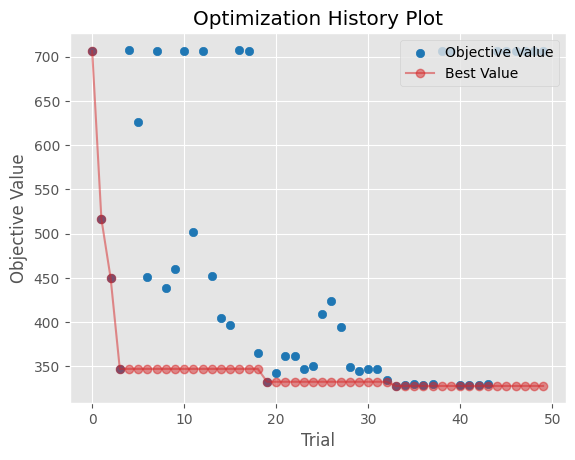

In [6]:
import matplotlib.pyplot as plt

fig = optuna.visualization.matplotlib.plot_optimization_history(study)
fig.legend(loc="upper right")